# Optimal hotel placement in Amsterdam

### Capstone project for Applied Data Science  

For this project I want to investigate what the optimal location for a new hotel in Amsterdam would be. The capital of the Netherlands is a popular destination for people all over the world with all it has to offer. This is also reflected in the number of hotels throughout the city. 

I selected 24 of the most centrally located boroughs of the city (all within the ring road) as options. There are already many hotels in Amsterdam, so I'd like to find the borough that meets the following criteria.

1- It has to be in the top 10 out of the selected boroughs in terms of **variety of food & drinks venues**

2- It should have **multiple museums** within walking distance

3- A **marijuana dispensary** should be in the vicinity of the hotel, because it remains one of the most sought after pleasures by tourists and, well, when in Rome... 

From the boroughs that meet the criteria, I will choose the one that has the **lowest density of hotels** (or other sleeping venues).

To conduct my analysis, I will use the Foursquare API. I will request which venues are within short walking distance of the centre of the borough. It seems though that the number of venues per api request (i.e. Borough) is limited to 100, so we have to keep that in mind when setting the parameters. For instance, the consequence of a too large radius is underrepresentation both in terms of number and variety of venues in a certain borough, so setting the right radius is paramount. 

I hope the data is as complete for Amsterdam as it was for Toronto and New York but don't expect it to be. Nevertheless, the analysis techniques are of importance here, not the results per se. 

I plan to use heatmaps and several other mapping techniques to arrive at my final recommendation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from geopy.geocoders import Nominatim
import folium

print('Libraries imported.')

Libraries imported.


In [2]:
ams = pd.read_csv('Geo_Amsterdam.csv')
ams.head()

,Borough,Latitude,Longitude
0,Amstelveld,52.363120,4.898801
1,Bos en Lommer,52.380688,4.855018
2,Dapperbuurt,52.363382,4.926996
3,De Baarsjes,52.369763,4.853405
4,De Krommerdt,52.371958,4.867156


In [3]:
# Leidseplein is the most central landmark of Amsterdam among the selected boroughs
address = 'Leidseplein, Amsterdam, the Netherlands'

geolocator = Nominatim(user_agent="ams_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Leidsplein are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Leidsplein are 52.3642355, 4.882745556059698.


In [4]:
# If above doesn't work, run this code (52.363781, 4.882163)
latitude = 52.3642355
longitude = 4.882745556059698

### Let's draw circles on the map of Amsterdam and determine an appropriate size of the radius as the criterion for walking distance. It can overlap but we don't want the circles to be too big ofcourse either, mainly because the api limits the number of venues returned per borough to 100. Setting the radius too big can lead to underrepresentation of the number and variety of venues in a certain borough.

In [5]:
# create map of Amsterdam using latitude and longitude values
map_ams = folium.Map(location=[latitude, longitude], zoom_start=13)

radius=600

# add markers to map
for lat, lng, borough in zip(ams['Latitude'], ams['Longitude'], ams['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=radius,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_ams)  
    
map_ams

### Let's connect to the Foursquare API and explore the neighborhoods

In [6]:
CLIENT_ID = 'PLJTCRSXWIGFNZWIE5XGDSEYL5CO3VIDKG3RN01YLUQIG0KN' # your Foursquare ID
CLIENT_SECRET = '53WTTCZKTMOOQP1DHBDPEIR4MM0VP1ZXADM22GE4A4YCHX4A' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 150 # A default Foursquare API limit value
print("Check!")

Check!


In [7]:
# Try the api with the first neighborhood in our df
ams.loc[0,'Borough']

'Amstelveld'

In [8]:
b_lat = ams.loc[0, 'Latitude'] # Borough latitude value
b_lng = ams.loc[0, 'Longitude'] # Borough longitude value

b_name = ams.loc[0, 'Borough'] # Borough name

print('Latitude and longitude values of {} are {}, {}.'.format(b_name, 
                                                               b_lat, 
                                                               b_lng))

Latitude and longitude values of Amstelveld are 52.36312, 4.898801.


### Now, let's get the top 100 venues that are around Amstelveld within the set radius.

In [58]:
import requests
# Set parameters and define url
limit = 150 # This doens't seem to work. Results still show only max 100 per borough.

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    b_lat, 
    b_lng, 
    radius, 
    limit)

# Send GET request and inspect results
results = requests.get(url).json()


In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Now we are ready to clean the json and structure it into a _pandas_ dataframe.

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

nearby_venues.head()

99 venues were returned by Foursquare.


,name,categories,lat,lng
0,Concerto Records,Record Shop,52.363454,4.898401
1,Cheesy Cakes,Dessert Shop,52.361595,4.899602
2,Bistrot des Alpes,French Restaurant,52.362000,4.901350
3,Waldorf Astoria Amsterdam,Hotel,52.364720,4.897004
4,Kaashuis Tromp,Cheese Shop,52.362529,4.898756


In [13]:
def getNearbyVenues(boroughs, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for borough, lat, lng in zip(boroughs, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
# Sometimes, this code gives a key error on 'Groups'. However, running it again normally solves this.
ams_venues = getNearbyVenues(boroughs = ams['Borough'], 
                             latitudes = ams['Latitude'],
                             longitudes = ams['Longitude']
                                  )

In [15]:
ams_venues.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amstelveld,52.36312,4.898801,Concerto Records,52.363454,4.898401,Record Shop
1,Amstelveld,52.36312,4.898801,Cheesy Cakes,52.361595,4.899602,Dessert Shop
2,Amstelveld,52.36312,4.898801,Bistrot des Alpes,52.362000,4.901350,French Restaurant
3,Amstelveld,52.36312,4.898801,Waldorf Astoria Amsterdam,52.364720,4.897004,Hotel
4,Amstelveld,52.36312,4.898801,Kaashuis Tromp,52.362529,4.898756,Cheese Shop


In [16]:
# Write to file (to use when api limits are reached)
ams_venues.to_csv()
ams_venues.shape

(1783, 7)

### Let's see how many venues the api returns per borough

In [17]:
borough_count = ams_venues.groupby(['Borough']).count().iloc[:,[2]]
borough_count

,Venue
Borough,
Amstelveld,99
Bos en Lommer,47
Dapperbuurt,69
De Baarsjes,45
De Krommerdt,87
De Pijp,100
De Wallen,82
Haarlemmerbuurt,100
Hoofddorppleinbuurt,60


In [18]:
#  And print the number of unique categories
print('There are {} uniques categories.'.format(len(ams_venues['Venue Category'].unique())))

There are 237 uniques categories.


### Let's recode the results into a few category groups

In [19]:
ams_venues.to_csv(r'export_ams_venues.csv') # export to csv, inspect the results and use in case the api stops working

In [20]:
# Make lists of search strings for each category group
eating = {
    'bagel',
    'bar',
    'beer',
    'bistro',
    'brewery',
    'cafe',
    'club',
    'coffee',
    'deli',
    'diner',
    'food',
    'friterie',
    'joint',
    'place',
    'pub',
    'restaurant',
    'spot',
    'steakhouse',
    'tea'}

shopping = {
    'boutique',
    'market',
    'shop',
    'store'}

sightseeing = {
    'art',
    'canal',
    'church',
    'comedy',
    'concert',
    'entertainment',
    'event space',
    'farm',
    'fountain',
    'garden',
    'historic',
    'marijuana',
    'monument',
    'museum',
    'music',
    'plaza',
    'pool',
    'road',
    'spa',
    'studio',
    'theater',
    'zoo'}

sleeping = {'bed','hostel','hotel'}

supermarket = {'supermarket', 'grocery'}

In [21]:
# Make new df for grouping
ams_catgroup = ams_venues

# Remove accents and lower case
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

    
ams_catgroup['venue_cat'] = ams_catgroup['Venue Category'].apply(remove_accents)
ams_catgroup['venue_cat'] = ams_catgroup['venue_cat'].str.lower()


ams_catgroup



,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,venue_cat
0,Amstelveld,52.363120,4.898801,Concerto Records,52.363454,4.898401,Record Shop,record shop
1,Amstelveld,52.363120,4.898801,Cheesy Cakes,52.361595,4.899602,Dessert Shop,dessert shop
2,Amstelveld,52.363120,4.898801,Bistrot des Alpes,52.362000,4.901350,French Restaurant,french restaurant
3,Amstelveld,52.363120,4.898801,Waldorf Astoria Amsterdam,52.364720,4.897004,Hotel,hotel
4,Amstelveld,52.363120,4.898801,Kaashuis Tromp,52.362529,4.898756,Cheese Shop,cheese shop
...,...,...,...,...,...,...,...,...
1778,Willemspark,52.353427,4.868105,Prince Henry Private Suites,52.354461,4.864346,Hotel,hotel
1779,Willemspark,52.353427,4.868105,Speeltuin Groot Melkhuis,52.358443,4.867929,Playground,playground
1780,Willemspark,52.353427,4.868105,Jumbo,52.351784,4.860430,Supermarket,supermarket
1781,Willemspark,52.353427,4.868105,Koninginneweg,52.352443,4.860377,Plaza,plaza


### Although Supermarkets and pharmacies are places where you can buy things, we don't consider them to be part of the **shopping** category group. **Shopping** includes the search term *market*, so we will divert supermarkets to **other** before moving to the next elif statement

In [23]:
def catgroup(cat):
    if any(s in cat for s in sleeping):
        return 'sleeping'
    elif any(s in cat for s in supermarket):
        return 'other'
    elif any(s in cat for s in shopping):
        return 'shopping'
    elif any(s in cat for s in eating):
        return 'eating'
    elif any(s in cat for s in sightseeing):
        return 'sightseeing'
    else:
        return 'other'
        

ams_catgroup['cat_group'] = ams_catgroup['venue_cat'].apply(catgroup)

ams_catgroup.head(15)

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,venue_cat,cat_group
0,Amstelveld,52.36312,4.898801,Concerto Records,52.363454,4.898401,Record Shop,record shop,shopping
1,Amstelveld,52.36312,4.898801,Cheesy Cakes,52.361595,4.899602,Dessert Shop,dessert shop,shopping
2,Amstelveld,52.36312,4.898801,Bistrot des Alpes,52.362000,4.901350,French Restaurant,french restaurant,eating
3,Amstelveld,52.36312,4.898801,Waldorf Astoria Amsterdam,52.364720,4.897004,Hotel,hotel,sleeping
4,Amstelveld,52.36312,4.898801,Kaashuis Tromp,52.362529,4.898756,Cheese Shop,cheese shop,shopping
5,Amstelveld,52.36312,4.898801,PAZ Open Fire Cooking,52.361325,4.899157,Steakhouse,steakhouse,eating
6,Amstelveld,52.36312,4.898801,Concerto Koffie,52.363551,4.898333,Coffee Shop,coffee shop,shopping
7,Amstelveld,52.36312,4.898801,Meat and Greek,52.362388,4.898873,Greek Restaurant,greek restaurant,eating
8,Amstelveld,52.36312,4.898801,Boerejongens,52.364876,4.897871,Marijuana Dispensary,marijuana dispensary,sightseeing
9,Amstelveld,52.36312,4.898801,The Lebanese Sajeria,52.363370,4.898388,Lebanese Restaurant,lebanese restaurant,eating


In [24]:
ams_catgroup.loc[ams_catgroup['venue_cat'] == 'supermarket'] # Good, these are correctly assigned to the 'other' category group

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,venue_cat,cat_group
127,Bos en Lommer,52.380688,4.855018,Vomar,52.379069,4.846611,Supermarket,supermarket,other
134,Bos en Lommer,52.380688,4.855018,Albert Heijn,52.381712,4.856172,Supermarket,supermarket,other
135,Bos en Lommer,52.380688,4.855018,Albert Heijn,52.378812,4.846764,Supermarket,supermarket,other
205,Dapperbuurt,52.363382,4.926996,Vomar,52.367583,4.926357,Supermarket,supermarket,other
207,Dapperbuurt,52.363382,4.926996,Albert Heijn,52.366553,4.924395,Supermarket,supermarket,other
249,De Baarsjes,52.369763,4.853405,Albert Heijn,52.371457,4.857647,Supermarket,supermarket,other
328,De Krommerdt,52.371958,4.867156,Albert Heijn,52.374809,4.860891,Supermarket,supermarket,other
410,De Pijp,52.354052,4.896669,Jumbo,52.357579,4.895801,Supermarket,supermarket,other
611,Haarlemmerbuurt,52.380435,4.888124,Jumbo,52.378547,4.883846,Supermarket,supermarket,other
662,Hoofddorppleinbuurt,52.351672,4.851630,DEEN Supermarkten,52.349317,4.849828,Supermarket,supermarket,other


In [25]:
# Group by cat_group and count uniques
ams_unique = pd.pivot_table(ams_catgroup, values='venue_cat', index=ams_catgroup['Borough'], columns=ams_catgroup['cat_group'], aggfunc=pd.Series.nunique, fill_value=0)
ams_unique


cat_group,eating,other,shopping,sightseeing,sleeping
Borough,,,,,
Amstelveld,26,7,12,9,2
Bos en Lommer,16,9,9,1,0
Dapperbuurt,26,9,6,5,1
De Baarsjes,17,8,9,4,1
De Krommerdt,37,4,8,7,2
De Pijp,34,9,17,4,1
De Wallen,21,4,17,9,1
Haarlemmerbuurt,26,3,15,5,1
Hoofddorppleinbuurt,27,4,9,3,0


## Borough overview

In [26]:
# Add unique eating category venues to borough_overview
borough_overview = borough_count
borough_overview = pd.merge(borough_overview, ams_unique['eating'], on='Borough')
borough_overview.columns = ['Venue count','Eating variety']
borough_overview.head(5)

,Venue count,Eating variety
Borough,,
Amstelveld,99,26
Bos en Lommer,47,16
Dapperbuurt,69,26
De Baarsjes,45,17
De Krommerdt,87,37


In [29]:
# Group by cat_group and count all
ams_count = pd.pivot_table(ams_catgroup, values='venue_cat', index=ams_catgroup['Borough'], columns=ams_catgroup['cat_group'], aggfunc=pd.Series.count, fill_value=0)
ams_count.head(5)

cat_group,eating,other,shopping,sightseeing,sleeping
Borough,,,,,
Amstelveld,49,7,16,17,10
Bos en Lommer,21,15,10,1,0
Dapperbuurt,38,11,10,9,1
De Baarsjes,21,9,10,4,1
De Krommerdt,56,6,12,9,4


In [30]:
# Group by cat_group and show diversity 
ams_perc = round((ams_unique/ams_count),2)
ams_perc = ams_perc.fillna(0)


In [32]:
ams_sleep = round((ams_count['sleeping']/borough_overview['Venue count']),2).replace(np.nan,0)
ams_sleep.name = 'ams_sleep'
ams_sleep.head(5)

Borough
Amstelveld       0.10
Bos en Lommer    0.00
Dapperbuurt      0.01
De Baarsjes      0.02
De Krommerdt     0.05
Name: ams_sleep, dtype: float64

### Looks good, we want to extract information regarding musea and marijuana in the area, so that we can combine this into one borough overview.

In [33]:
# First, make a dummy variable for musea
ams_catgroup['museum'] = ams_catgroup['venue_cat'].str.contains('museum').astype(int)
# List all musea
ams_catgroup.loc[ams_catgroup['venue_cat'].str.contains("museum")]


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,venue_cat,cat_group,museum
24,Amstelveld,52.363120,4.898801,Foam,52.363984,4.893353,Art Museum,art museum,sightseeing,1
31,Amstelveld,52.363120,4.898801,Hermitage Amsterdam,52.365492,4.903190,Art Museum,art museum,sightseeing,1
46,Amstelveld,52.363120,4.898801,Museum Van Loon,52.363611,4.893334,Museum,museum,sightseeing,1
77,Amstelveld,52.363120,4.898801,Joods Historisch Museum,52.367228,4.904140,History Museum,history museum,sightseeing,1
172,Dapperbuurt,52.363382,4.926996,Tropenmuseum,52.362701,4.922481,Museum,museum,sightseeing,1
445,De Pijp,52.354052,4.896669,Heineken Experience,52.358000,4.891677,Museum,museum,sightseeing,1
468,De Wallen,52.371750,4.897660,Het Rembrandthuis,52.369350,4.901332,History Museum,history museum,sightseeing,1
483,De Wallen,52.371750,4.897660,Museum Ons' Lieve Heer op Solder,52.375144,4.899414,Museum,museum,sightseeing,1
713,Jordaan,52.377211,4.881170,Electric Ladyland - Museum of Fluorescent Art,52.375608,4.880822,Art Museum,art museum,sightseeing,1
715,Jordaan,52.377211,4.881170,Pianola Museum,52.378526,4.883611,Museum,museum,sightseeing,1


In [34]:
# Group by Borough
museum = ams_catgroup.groupby(['Borough'])['museum'].sum()
# Add number of museums to borough_overview
borough_overview = pd.merge(borough_overview, museum, on='Borough')
borough_overview.columns = ['Venue count','Eating variety','Museum count']



In [35]:
# Now do the same for venues related to marijuana
ams_catgroup['marijuana'] = ams_catgroup['venue_cat'].str.contains('marijuana').astype(int)
marijuana = ams_catgroup.groupby(['Borough'])['marijuana'].sum()

# Add number of marijuana dispensaries to borough_overview
borough_overview = pd.merge(borough_overview, marijuana, on='Borough')
borough_overview.columns = ['Venue count','Eating variety','Museum count','Marijuana count']

In [36]:
# Finally, add ratio of sleeping venues to borough_overview, and sort
borough_overview = pd.merge(borough_overview, ams_sleep, on='Borough')
borough_overview.columns = ['Venue count','Eating variety','Museum count','Marijuana count','Sleeping ratio']

borough_overview = borough_overview.sort_values(by=['Eating variety'], ascending=False)
borough_overview

,Venue count,Eating variety,Museum count,Marijuana count,Sleeping ratio
Borough,,,,,
De Krommerdt,87,37,0,1,0.05
Oud-West,100,34,0,1,0.03
De Pijp,100,34,1,2,0.01
Jordaan,100,29,2,2,0.07
Hoofddorppleinbuurt,60,27,0,0,0.00
Weesperzijde,69,27,0,0,0.09
Spiegelbuurt,100,27,4,4,0.04
Amstelveld,99,26,4,3,0.10
Haarlemmerbuurt,100,26,0,1,0.03


Make a separate dataframe for kmeans clustering later on using the borough overview and the other aggregated data

In [37]:
# Normalize values 
x = borough_overview.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
borough_cluster = pd.DataFrame(x_scaled)

borough_cluster.head(5)

,0,1,2,3,4
0,0.845238,1.000000,0.000000,0.25,0.263158
1,1.000000,0.903226,0.000000,0.25,0.157895
2,1.000000,0.903226,0.166667,0.50,0.052632
3,1.000000,0.741935,0.333333,0.50,0.368421
4,0.523810,0.677419,0.000000,0.00,0.000000


## Borough selection after criteria applied

In [39]:
# First take the top 10 in terms of eating variety. It's already sorted so can just use head(10)
borough_select = borough_overview.sort_values(by=['Eating variety'], ascending=False).head(10)
borough_select

# Drop boroughs with less than 2 museums
drop1 = borough_select[borough_select['Museum count']<2].index
borough_select = borough_select.drop(drop1)

# Drop boroughs without marijuana dispensaries
drop2 = borough_select[borough_select['Marijuana count']==0].index
borough_select = borough_select.drop(drop2)

# Show selection
borough_select.reset_index()

,Borough,Venue count,Eating variety,Museum count,Marijuana count,Sleeping ratio
0,Jordaan,100,29,2,2,0.07
1,Spiegelbuurt,100,27,4,4,0.04
2,Amstelveld,99,26,4,3,0.10


## Preliminary results 

So it seems there are only 3 eligible boroughs after the selection criteria are applied. \
Spiegelbuurt seems to be the best choice here with a large variety of venues and a low density of sleeping venues. \
Let's examine the results further by looking at some heatmaps and frequency tables

## Heatmaps
### Add a heatmap of sleeping facilities onto the previously rendered map of Amsterdam with its boroughs

In [40]:
# load plugins
from folium import plugins
from folium.plugins import HeatMap

# Select the location data of sleeping venues
df_sleep = ams_catgroup.loc[ams_catgroup['cat_group'] == 'sleeping']
sleep_lat = df_sleep['Venue Latitude']
sleep_lon = df_sleep['Venue Longitude']
sleep_latlons = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in df_sleep.iterrows()]


In [41]:
# Now construct a heatmap layer and render it onto the map of Amsterdam
hm_sleep = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough in zip(ams['Latitude'], ams['Longitude'], ams['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=radius,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(hm_sleep)  

# Make heatmap layer    
folium.TileLayer('cartodbpositron').add_to(hm_sleep)
HeatMap(sleep_latlons, name = 'sleep').add_to(hm_sleep)
folium.LayerControl().add_to(hm_sleep)
hm_sleep

#### Now make additional heatmaps for the other category groups

Eating

In [42]:
# Unfortunately, it didn't work to get all these heatmpas as additional layers to my existing map, so I made a separate one for each category group
# Select the location data of eating venues
df_eat = ams_catgroup.loc[ams_catgroup['cat_group'] == 'eating']

eat_latlons = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in df_eat.iterrows()]

# Construct a heatmap layer and render it onto the map of Amsterdam
hm_eat = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough in zip(ams['Latitude'], ams['Longitude'], ams['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=600,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(hm_eat)  

# Make heatmap layer    
folium.TileLayer('cartodbpositron').add_to(hm_eat)
HeatMap(eat_latlons, name = 'sleep').add_to(hm_eat) 
folium.LayerControl().add_to(hm_eat)
hm_eat


Shopping

In [43]:
# Select the location data of shopping venues
df_shop = ams_catgroup.loc[ams_catgroup['cat_group'] == 'shopping']

shop_latlons = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in df_shop.iterrows()]

# Construct a heatmap layer and render it onto the map of Amsterdam
hm_shop = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough in zip(ams['Latitude'], ams['Longitude'], ams['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=600,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(hm_shop)  

# Make heatmap layer    
folium.TileLayer('cartodbpositron').add_to(hm_shop)
HeatMap(shop_latlons, name = 'shop').add_to(hm_shop) 
folium.LayerControl().add_to(hm_shop)
hm_shop


Sightseeing

In [44]:
# Select the location data of sightseeing venues
df_sight = ams_catgroup.loc[ams_catgroup['cat_group'] == 'sightseeing']

sight_latlons = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in df_sight.iterrows()]

# Construct a heatmap layer and render it onto the map of Amsterdam
hm_sight = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough in zip(ams['Latitude'], ams['Longitude'], ams['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=600,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(hm_sight)  

# Make heatmap layer    
folium.TileLayer('cartodbpositron').add_to(hm_sight)
HeatMap(sight_latlons, name = 'sight').add_to(hm_sight) 
folium.LayerControl().add_to(hm_sight)
hm_sight


#### It's clear that all three selected broughs have a high density of all sorts of venues.

In [45]:
# Finally, make dummy variables for all cat_groups

ams_catgroup['Sleeping'] = ams_catgroup['cat_group'].str.contains('sleeping').astype(int)
ams_catgroup['Eating'] = ams_catgroup['cat_group'].str.contains('eating').astype(int)
ams_catgroup['Sightseeing'] = ams_catgroup['cat_group'].str.contains('sightseeing').astype(int)
ams_catgroup['Shopping'] = ams_catgroup['cat_group'].str.contains('shopping').astype(int)
ams_catgroup['Other'] = ams_catgroup['cat_group'].str.contains('other').astype(int)


### One hot encoding and frequency

In [46]:
# one hot encoding
ams_onehot = pd.get_dummies(ams_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
ams_onehot['Borough'] = ams_venues['Borough']

# move neighborhood column to the first column
fixed_columns = [ams_onehot.columns[-1]] + list(ams_onehot.columns[:-1])
ams_onehot = ams_onehot[fixed_columns]
cols_to_move = ['Borough']
ams_onehot = ams_onehot[ cols_to_move + [ col for col in ams_onehot.columns if col not in cols_to_move ] ]

print(ams_onehot.shape)

ams_onehot.head()

(1783, 238)


,Borough,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amstelveld,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amstelveld,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amstelveld,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amstelveld,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amstelveld,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Now group borough and take the mean to show venue occurrence per borough
ams_grouped = ams_onehot.groupby(['Borough']).mean().reset_index()
ams_grouped.head(5)

,Borough,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amstelveld,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.0,0.020202,...,0.000000,0.010101,0.0,0.000000,0.000000,0.000000,0.010101,0.010101,0.0,0.000000
1,Bos en Lommer,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.042553,0.000000,0.0,0.021277,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,Dapperbuurt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.014493,0.000000,0.0,0.014493,0.014493,0.000000,0.000000,0.014493,0.0,0.072464
3,De Baarsjes,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,De Krommerdt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.022989,0.011494,0.0,0.000000,0.011494,0.011494,0.000000,0.022989,0.0,0.000000


### Let's summarize the most popular venue info per borough into one table

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Borough'] = ams_grouped['Borough']

for ind in np.arange(ams_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(ams_grouped.iloc[ind, :], num_top_venues)

venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amstelveld,Hotel,French Restaurant,Coffee Shop,Café,Italian Restaurant,Bar,Restaurant,Steakhouse,Movie Theater,Plaza
1,Bos en Lommer,Bar,Supermarket,Grocery Store,Coffee Shop,Bakery,Vegetarian / Vegan Restaurant,Park,Playground,Indonesian Restaurant,Café
2,Dapperbuurt,Zoo Exhibit,Bar,Café,Market,Restaurant,Turkish Restaurant,Ice Cream Shop,Bakery,Coffee Shop,Supermarket
3,De Baarsjes,Restaurant,Deli / Bodega,Bar,Gym / Fitness Center,Coffee Shop,Cocktail Bar,Supermarket,Gift Shop,Electronics Store,Spa
4,De Krommerdt,Italian Restaurant,Bar,Coffee Shop,Pizza Place,Grocery Store,Hotel,Modern European Restaurant,Dutch Restaurant,Café,Cocktail Bar
5,De Pijp,Coffee Shop,Italian Restaurant,Pizza Place,Bakery,Breakfast Spot,Deli / Bodega,French Restaurant,Food Truck,South American Restaurant,Juice Bar
6,De Wallen,Hotel,Bar,Coffee Shop,Cheese Shop,Plaza,French Restaurant,Chinese Restaurant,Bookstore,Thai Restaurant,Burger Joint
7,Haarlemmerbuurt,Bar,Sandwich Place,Café,Italian Restaurant,Coffee Shop,Cosmetics Shop,Bistro,Hotel,Bakery,Deli / Bodega
8,Hoofddorppleinbuurt,Coffee Shop,Café,Restaurant,Italian Restaurant,Bar,Bakery,Breakfast Spot,Wine Shop,Gym / Fitness Center,Food Service
9,Jordaan,Bar,Café,Italian Restaurant,Hotel,Coffee Shop,Sandwich Place,Seafood Restaurant,Indian Restaurant,Bistro,Indonesian Restaurant


### Clustering analysis

Run _k_-means to cluster the neighborhood into a few clusters.

In [50]:
# k means determine k
distortions = []

K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(borough_cluster)
    kmeanModel.fit(borough_cluster)
    distortions.append(sum(np.min(cdist(borough_cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / borough_cluster.shape[0])



C:\Users\mauri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mauri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


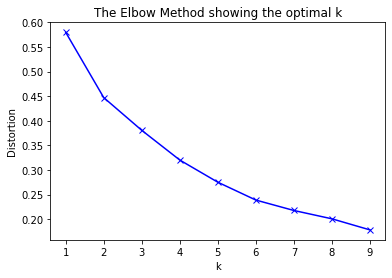

In [51]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Not a clear elbow in the graph, so the optimal number of clusters is after trial and error arbitrarily set at 5

In [52]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(borough_overview)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 3, 3, 0, 0, 0, 3])

In [54]:
# add clustering labels
# ams_cluster.drop('Cluster Labels', axis=1, inplace=True) # Turn on and off between iterations with different kclusters
ams_cluster = venues_sorted
ams_cluster = ams_cluster.insert(0, 'Cluster Labels', kmeans.labels_)
ams_cluster

In [55]:
# merge grouped with geo data to add latitude/longitude for each neighborhood
ams_merged = ams

ams_merged = ams_merged.join(venues_sorted.set_index('Borough'), on='Borough', how='right')

ams_merged # check the last columns!


,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amstelveld,52.363120,4.898801,0,Hotel,French Restaurant,Coffee Shop,Café,Italian Restaurant,Bar,Restaurant,Steakhouse,Movie Theater,Plaza
1,Bos en Lommer,52.380688,4.855018,0,Bar,Supermarket,Grocery Store,Coffee Shop,Bakery,Vegetarian / Vegan Restaurant,Park,Playground,Indonesian Restaurant,Café
2,Dapperbuurt,52.363382,4.926996,0,Zoo Exhibit,Bar,Café,Market,Restaurant,Turkish Restaurant,Ice Cream Shop,Bakery,Coffee Shop,Supermarket
3,De Baarsjes,52.369763,4.853405,0,Restaurant,Deli / Bodega,Bar,Gym / Fitness Center,Coffee Shop,Cocktail Bar,Supermarket,Gift Shop,Electronics Store,Spa
4,De Krommerdt,52.371958,4.867156,3,Italian Restaurant,Bar,Coffee Shop,Pizza Place,Grocery Store,Hotel,Modern European Restaurant,Dutch Restaurant,Café,Cocktail Bar
5,De Pijp,52.354052,4.896669,3,Coffee Shop,Italian Restaurant,Pizza Place,Bakery,Breakfast Spot,Deli / Bodega,French Restaurant,Food Truck,South American Restaurant,Juice Bar
6,De Wallen,52.371750,4.897660,0,Hotel,Bar,Coffee Shop,Cheese Shop,Plaza,French Restaurant,Chinese Restaurant,Bookstore,Thai Restaurant,Burger Joint
7,Haarlemmerbuurt,52.380435,4.888124,0,Bar,Sandwich Place,Café,Italian Restaurant,Coffee Shop,Cosmetics Shop,Bistro,Hotel,Bakery,Deli / Bodega
8,Hoofddorppleinbuurt,52.351672,4.851630,0,Coffee Shop,Café,Restaurant,Italian Restaurant,Bar,Bakery,Breakfast Spot,Wine Shop,Gym / Fitness Center,Food Service
9,Jordaan,52.377211,4.881170,3,Bar,Café,Italian Restaurant,Hotel,Coffee Shop,Sandwich Place,Seafood Restaurant,Indian Restaurant,Bistro,Indonesian Restaurant


### Time to visualize the results!

In [56]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ams_merged['Latitude'], ams_merged['Longitude'], ams_merged['Borough'], ams_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=radius,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.3).add_to(map_clusters)
       
map_clusters

## Conclusion
The resulting figure above shows where the three different types of boroughs are located. The results are somewhat surprising and as an Amsterdam resident I don't believe this is an accurate clustering classification. The problem is probably the underlying data which might not be large enough to be representative in Amsterdam.\
If anything, the following can be deduced: 
- Our top location of choice thus far is **Spiegelbuurt**, which is the only purple borough in the centre of the city, a possible indication that the area stands out amongst its neighboring boroughs. However, you don't expect it to 'look' like the other purple areas which are mainly residential.
- Green and blue cluster are somewhat alike (from my experience) but it's hard to pinpoint what data is mainly responsible for clustering these boroughs together

More and better data is needed to make useful machine learning recommendations. For now, the table below gives the best indications for where to start a new hotel in Amsterdam.


In [57]:
borough_overview = borough_overview.sort_values(by=['Borough'])
borough_overview

,Venue count,Eating variety,Museum count,Marijuana count,Sleeping ratio
Borough,,,,,
Amstelveld,99,26,4,3,0.10
Bos en Lommer,47,16,0,0,0.00
Dapperbuurt,69,26,1,0,0.01
De Baarsjes,45,17,0,0,0.02
De Krommerdt,87,37,0,1,0.05
De Pijp,100,34,1,2,0.01
De Wallen,82,21,2,0,0.09
Haarlemmerbuurt,100,26,0,1,0.03
Hoofddorppleinbuurt,60,27,0,0,0.00
